In [17]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import datetime
import math
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import scale as sklearn_scale
from collections import deque

In [18]:
data = pd.read_csv("data/csv/still/0/wo_1_2_0.csv")

data.head()

,timestamps,csi_len,channel,err_info,noise_floor,rate,bandWidth,num_tones,nr,nc,...,payload_length,block_length,subcarriers,ant1_amplitude,ant2_amplitude,ant1_phase,ant2_phase,with_receiver,coord1,coord2
0,440878822,560,2437,0,0,140,0,56,2,2,...,1320,1904,1,148.758193,100.955436,1.469790,-0.982794,0,1,2
1,440878822,560,2437,0,0,140,0,56,2,2,...,1320,1904,2,152.322027,183.221178,-0.560687,2.448951,0,1,2
2,440878822,560,2437,0,0,140,0,56,2,2,...,1320,1904,3,154.055185,106.677083,1.453688,-1.040023,0,1,2
3,440878822,560,2437,0,0,140,0,56,2,2,...,1320,1904,4,156.160174,194.164878,-0.575570,2.421794,0,1,2
4,440878822,560,2437,0,0,140,0,56,2,2,...,1320,1904,5,156.416112,104.043260,1.436132,-0.956133,0,1,2


In [19]:
variances = data.var()
print(variances)

low_variance_cols = variances[variances < 5e-3].index.tolist()
print("Columns with low or zero variance:")
print(low_variance_cols)

timestamps        4.906466e+10
csi_len           4.948542e+03
channel           0.000000e+00
err_info          0.000000e+00
noise_floor       0.000000e+00
rate              4.635199e+00
bandWidth         0.000000e+00
num_tones         0.000000e+00
nr                0.000000e+00
nc                6.311915e-02
rssi              7.682875e+00
rssi1             3.422197e+00
rssi2             9.843349e+00
rssi3             0.000000e+00
payload_length    1.439675e+04
block_length      2.119725e+04
subcarriers       2.612566e+02
ant1_amplitude    2.538223e+03
ant2_amplitude    4.968388e+03
ant1_phase        3.364653e+00
ant2_phase        3.281459e+00
with_receiver     0.000000e+00
coord1            0.000000e+00
coord2            0.000000e+00
dtype: float64
Columns with low or zero variance:
['channel', 'err_info', 'noise_floor', 'bandWidth', 'num_tones', 'nr', 'rssi3', 'with_receiver', 'coord1', 'coord2']


In [20]:
data.drop(low_variance_cols, axis=1, inplace=True)
data.drop(['csi_len', 'rate', 'payload_length', 'block_length'], axis=1, inplace=True)
data.drop('timestamps', axis=1, inplace=True)
data.head()

,nc,rssi,rssi1,rssi2,subcarriers,ant1_amplitude,ant2_amplitude,ant1_phase,ant2_phase
0,2,59,54,57,1,148.758193,100.955436,1.469790,-0.982794
1,2,59,54,57,2,152.322027,183.221178,-0.560687,2.448951
2,2,59,54,57,3,154.055185,106.677083,1.453688,-1.040023
3,2,59,54,57,4,156.160174,194.164878,-0.575570,2.421794
4,2,59,54,57,5,156.416112,104.043260,1.436132,-0.956133


In [21]:
# features_to_scale = ['csi_len', 'payload_length', 'block_length', 'ant1_amplitude', 'ant2_amplitude', 'ant1_phase', 'ant2_phase', 'rssi', 'rssi1', 'rssi2']
features_to_scale = ['ant1_phase', 'ant2_phase', 'rssi', 'rssi1', 'rssi2']
scaler = StandardScaler()

# Apply standardization on features
# data = data_cleaned.copy()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])
data.head()

,nc,rssi,rssi1,rssi2,subcarriers,ant1_amplitude,ant2_amplitude,ant1_phase,ant2_phase
0,2,-0.301753,-0.056421,-0.426633,1,148.758193,100.955436,0.775383,-0.566127
1,2,-0.301753,-0.056421,-0.426633,2,152.322027,183.221178,-0.331581,1.328339
2,2,-0.301753,-0.056421,-0.426633,3,154.055185,106.677083,0.766604,-0.597720
3,2,-0.301753,-0.056421,-0.426633,4,156.160174,194.164878,-0.339695,1.313347
4,2,-0.301753,-0.056421,-0.426633,5,156.416112,104.043260,0.757034,-0.551410


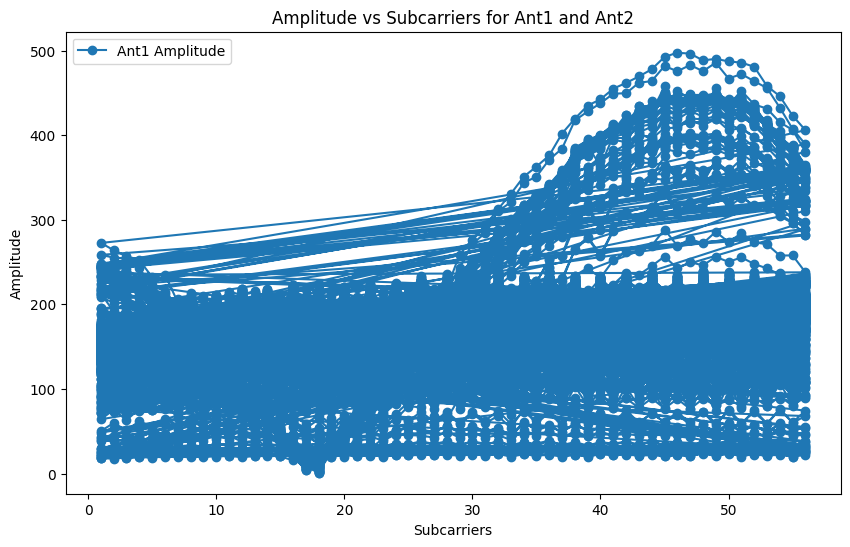

In [23]:
# Plotting the data
plt.figure(figsize=(10, 6))

# Plot Ant1 and Ant2 amplitudes
plt.plot(data["subcarriers"], data["ant1_amplitude"], label="Ant1 Amplitude", marker='o')
# plt.plot(data["subcarriers"], data["ant2_amplitude"], label="Ant2 Amplitude", marker='x')

# Adding labels and title
plt.xlabel("Subcarriers")
plt.ylabel("Amplitude")
plt.title("Amplitude vs Subcarriers for Ant1 and Ant2")
plt.legend()

# Show the plot
plt.show()

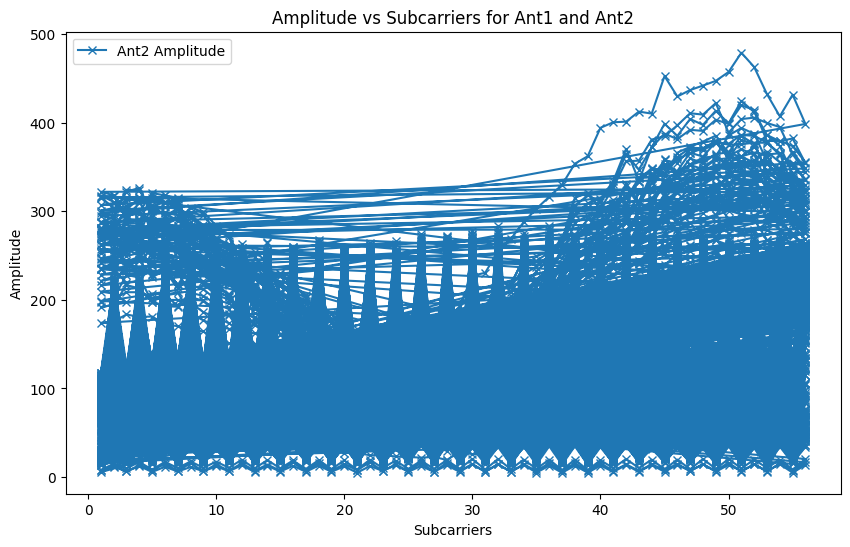

In [24]:
# Plotting the data
plt.figure(figsize=(10, 6))

# Plot Ant1 and Ant2 amplitudes
# plt.plot(data["subcarriers"], data["ant1_amplitude"], label="Ant1 Amplitude", marker='o')
plt.plot(data["subcarriers"], data["ant2_amplitude"], label="Ant2 Amplitude", marker='x')

# Adding labels and title
plt.xlabel("Subcarriers")
plt.ylabel("Amplitude")
plt.title("Amplitude vs Subcarriers for Ant1 and Ant2")
plt.legend()

# Show the plot
plt.show()

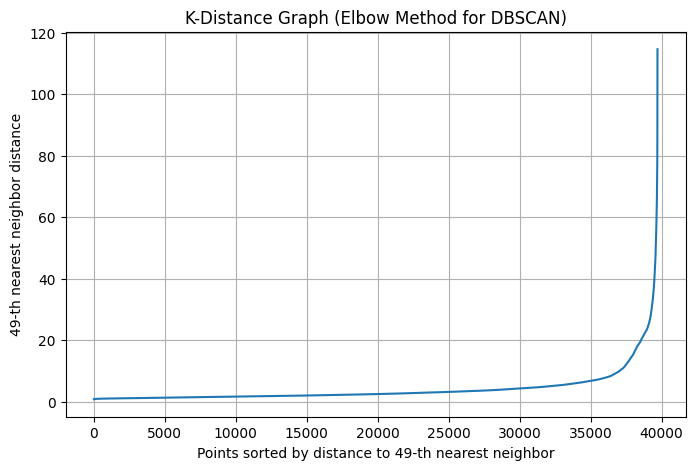

In [6]:
# Step 1: Extract your data (using the amplitude data as an example)
X = data[['ant1_amplitude', 'ant2_amplitude']].values

# Step 2: Use Nearest Neighbors to find the k nearest neighbors
k = 49  # min_samples - 1 for DBSCAN, for example, min_samples = 5, so k = 4
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Step 3: Sort the distances to the k-th nearest neighbor
# The distance to the k-th nearest neighbor is in the last column (index k-1)
k_distances = distances[:, k-1]
k_distances = np.sort(k_distances)

# Step 4: Plot the sorted k-distance graph
plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.xlabel('Points sorted by distance to {}-th nearest neighbor'.format(k))
plt.ylabel('{}-th nearest neighbor distance'.format(k))
plt.title('K-Distance Graph (Elbow Method for DBSCAN)')
plt.grid(True)
plt.show()

In [7]:
# def find_optimal_eps(data, MinPts=5):
#     # Compute the pairwise distance matrix
#     data_dist_matrix = pdist(data)
#     data_dist_matrix = squareform(data_dist_matrix)
    
#     n1 = data.shape[0]

#     # Sort distances to find the MinPts+1 nearest distances for each point
#     sorted_distances = np.sort(data_dist_matrix, axis=1)
#     k_distances = sorted_distances[:, MinPts]

#     # Sort and find the distance values for plotting
#     dist_eps = np.sort(k_distances)

#     # Create a K-distance plot to help find Eps value
#     plt.plot(range(1, len(dist_eps) + 1), dist_eps)
#     plt.xlabel("Points")
#     plt.ylabel(f"{MinPts}-Distance")
#     plt.title("K-Distance Graph")
#     plt.show()

#     # Find the optimal Eps by identifying a steep change in the curve
#     eps_diffs = np.diff(dist_eps)
#     highnumb_index = np.argmax(eps_diffs)  # Find the point where the curve has the steepest increase
#     eps = (dist_eps[highnumb_index] + dist_eps[highnumb_index + 1]) / 2

#     print(f"Optimal Eps value: {eps}")
#     return eps

# eps_values = find_optimal_eps(data)

In [8]:
amplitudes = data[['ant1_amplitude', 'ant2_amplitude']].values
# dbscan = hdbscan.HDBSCAN(min_samples=10, core_dist_n_jobs=-1)
dbscan = DBSCAN(eps=25, min_samples=50)

In [9]:
dbscan.fit(amplitudes)

DBSCAN(eps=25, min_samples=50)

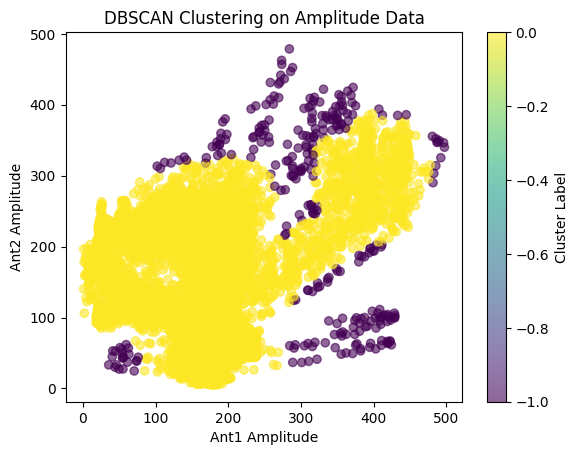

In [10]:
data['cluster'] = dbscan.labels_

data.head()

# Step 5: Visualize the clusters
plt.scatter(data['ant1_amplitude'], data['ant2_amplitude'], c=data['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Ant1 Amplitude')
plt.ylabel('Ant2 Amplitude')
plt.title('DBSCAN Clustering on Amplitude Data')
plt.colorbar(label='Cluster Label')
plt.show()

In [11]:
from sklearn.metrics import silhouette_score


score = silhouette_score(data, dbscan.labels_)
print(score)

from sklearn.metrics import davies_bouldin_score
score = davies_bouldin_score(data, dbscan.labels_)
print(f"Davies-Bouldin Score: {score}")

from sklearn.metrics import calinski_harabasz_score
score = calinski_harabasz_score(data, dbscan.labels_)
print(f"Calinski-Harabasz Score: {score}")


0.562641912191625
Davies-Bouldin Score: 1.3980197056461867
Calinski-Harabasz Score: 1047.9567633697723


In [12]:
data.head()

,nc,rssi,rssi1,rssi2,subcarriers,ant1_amplitude,ant2_amplitude,ant1_phase,ant2_phase,cluster
0,2,-0.301753,-0.056421,-0.426633,1,148.758193,100.955436,0.775383,-0.566127,0
1,2,-0.301753,-0.056421,-0.426633,2,152.322027,183.221178,-0.331581,1.328339,0
2,2,-0.301753,-0.056421,-0.426633,3,154.055185,106.677083,0.766604,-0.597720,0
3,2,-0.301753,-0.056421,-0.426633,4,156.160174,194.164878,-0.339695,1.313347,0
4,2,-0.301753,-0.056421,-0.426633,5,156.416112,104.043260,0.757034,-0.551410,0


In [13]:
cleaned_data = data.drop(data[data.cluster < 0].index)
cleaned_data.head()

,nc,rssi,rssi1,rssi2,subcarriers,ant1_amplitude,ant2_amplitude,ant1_phase,ant2_phase,cluster
0,2,-0.301753,-0.056421,-0.426633,1,148.758193,100.955436,0.775383,-0.566127,0
1,2,-0.301753,-0.056421,-0.426633,2,152.322027,183.221178,-0.331581,1.328339,0
2,2,-0.301753,-0.056421,-0.426633,3,154.055185,106.677083,0.766604,-0.597720,0
3,2,-0.301753,-0.056421,-0.426633,4,156.160174,194.164878,-0.339695,1.313347,0
4,2,-0.301753,-0.056421,-0.426633,5,156.416112,104.043260,0.757034,-0.551410,0


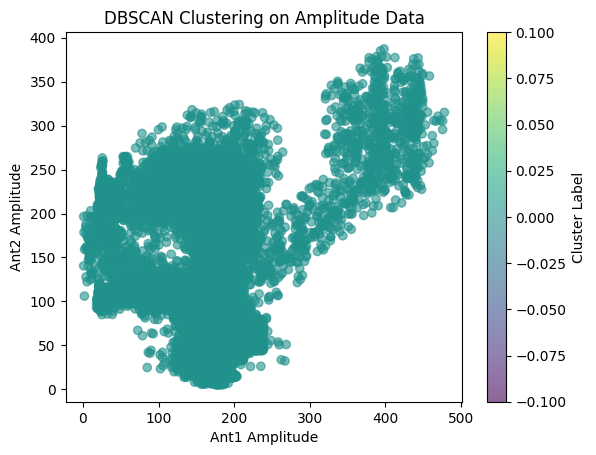

In [14]:
plt.scatter(cleaned_data['ant1_amplitude'], cleaned_data['ant2_amplitude'], c=cleaned_data['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Ant1 Amplitude')
plt.ylabel('Ant2 Amplitude')
plt.title('DBSCAN Clustering on Amplitude Data')
plt.colorbar(label='Cluster Label')
plt.show()

In [15]:
score = silhouette_score(data, dbscan.labels_)
print(score)

0.562641912191625


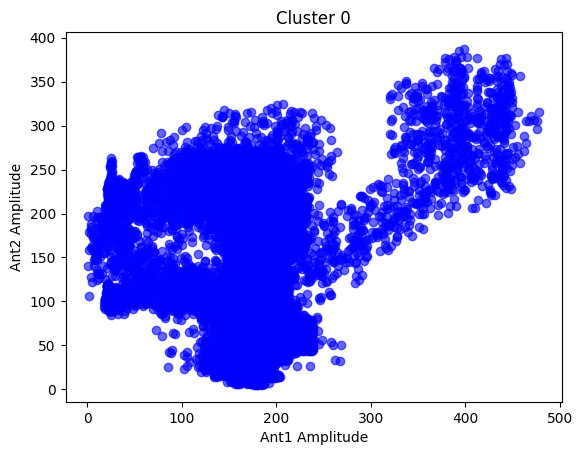

In [16]:
import matplotlib.pyplot as plt

# Extract points from Cluster 0
cluster_0_points = data[data.cluster == 0]

# Plot Cluster 0
plt.scatter(cluster_0_points['ant1_amplitude'], cluster_0_points['ant2_amplitude'], c='blue', alpha=0.6)
plt.xlabel('Ant1 Amplitude')
plt.ylabel('Ant2 Amplitude')
plt.title('Cluster 0')
plt.show()
